In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#path_wd='drive/MyDrive/MINDAT Aspectos Avanzados/lulc-classification'
#os.chdir(path_wd)

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


Cargamos las bibliotecas necesarias

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.utils import np_utils
import cv2
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers  #Para definición de capas
from numpy.random import seed           #Para controlar generación de pesos
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Para procesado de imágenes
import tensorflow.random
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Para procesado de imágenes

from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split

from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101

Consideramos unas semillas aleatorias para garantizar reproducibilidad en los experimentos

In [4]:
seed(1)
tensorflow.random.set_seed(0)

Fijamos los paths donde se encuentran las imagenes

In [5]:
train_dir = "./Sentinel2LULC_354/Sentinel2LULC_354"
test_dir = "./Test 2/Test 2"
weights_file = None

Vamos a definir funciones auxiliares que nos ayudarán a visualizar diferentes aspectos

La primera función irá destinada a calcular la precisión total del modelo

In [6]:
def calcularAccuracy(labels, preds):
  accuracy = sum(labels == preds)/len(labels)
  return accuracy

Vamos a hacer también una función para calcular la precisión por clase en el modelo

In [7]:
def calcularAccuracyClases(labels, preds):
  well_pred = np.zeros(labels.shape[1]).tolist()
  total = np.zeros(labels.shape[1]).tolist()

  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)

  for i in len(labels):
    total[labels[i]] += 1
    if labels[i] == preds[i]:
      well_pred[labels[i]] += 1
  
  for i in len(well_pred):
    well_pred[i] /= float(total[i])
  
  return well_pred

Vamos a hacer una función también para visualizar la evolución de la medida de interés (accuracy en este caso) en entrenamiento y validación para cada época

In [8]:
def mostrarEvolucion(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy','Validation accuracy'])
  plt.ylim(0,1)           #Meto esto para mejor comparación de gráficas
  plt.show()

Realizamos la lectura de las imagenes

In [9]:
print("--- LECTURA DE IMÁGENES ---")

print("- Cargando imágenes de entrenamiento...")

x_train = []
y_train = []

for root, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".jpg"):               
            x_train.append(cv2.imread(os.path.join(root, file), 1))
            y_train.append(int(file.split("_")[0]))

x_test = []
y_test = []
names_test = []

print("- Cargando imágenes de test...")

for root, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".jpg"):               
            x_test.append(cv2.imread(os.path.join(root, file), 1))
            y_test.append(int(file.split("_")[0]))
            names_test.append(file)


# Creación de las subclases que se han considerado:
# 
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

train, val = train_test_split(np.arange(len(y_train)), test_size=0.1, random_state=5, stratify=y_train)

x_val = x_train[val]
y_val = y_train[val]
y_train = y_train[train]
x_train = x_train[train]


--- LECTURA DE IMÁGENES ---
- Cargando imágenes de entrenamiento...
- Cargando imágenes de test...


In [10]:
# Vamos a trabajar ahora en hacer una agrupación de las clases por grupos similares 

dict_clases = {1:1, 2:2, 3:3, 4:4, 5:4, 6:5, 7:6, 8:7, 9:8, 10:8,
               11:8, 12:9, 13:10, 14:11, 15:12, 16:12, 17:13, 18:14, 19:14, 20:14,
               21:15, 22:15, 23:16, 24:17, 25:18, 26:18, 27:18, 28:18, 29:19}


In [11]:
# Parámetros para la ejecucción
subida = "9"
load_file = 'david/modelos/model' +subida + '.h5'
batch_size = 32
shuffle_buffer_size = 1000
nclasses = 19
epochs = 50
jerarquico = False


if jerarquico:
    # Hay por tanto 6 agrupaciones.
    y_train_general = np.array([dict_clases[key] for key in y_train])
    y_val_general = np.array([dict_clases[key] for key in y_val])
    y_test_general = np.array([dict_clases[key] for key in y_test])
    axlabs = [
    "1_BarrenLands",
    "2_MossAndLichen",
    "3_MossAndLichen",
    "4_Srubland",
    "5_ForestsOpDeBr",
    "6_ForestClDeBr",
    "7_ForestsDeDeBr",
    "8_Forest1",
    "9_ForestsOpEvBr",
    "10_ForestsClEvBr",
    "11_ForestsDeEvBr",
    "12_Forest2",
    "13_ForestsDeEvNe",
    "14_Wetland",
    "15_Water",
    "16_PermanentSnow",
    "17_CropSeasWater",
    "18_Crop",
    "19_UrbanBlUpArea",

  ]
else:
    y_train_general = y_train
    y_val_general = y_val
    y_test_general = y_test
    axlabs = [
    "1_BarrenLands",
    "2_MossAndLichen",
    "3_MossAndLichen",
    "4_SrublandOpen",
    "5_SrublandClose",
    "6_ForestsOpDeBr",
    "7_ForestClDeBr",
    "8_ForestsDeDeBr",
    "9_ForestsOpDeNe",
    "10_ForestsClDeNe",
    "11_ForestsDeDeNe",
    "12_ForestsOpEvBr",
    "13_ForestsClEvBr",
    "14_ForestsDeEvBr",
    "15_ForestsOpEvNe",
    "16_ForestsClEvNe",
    "17_ForestsDeEvNe",
    "18_WetlandMangro",
    "19_WetlandSwamps",
    "20_WetlandMarshl",
    "21_WaterBodyMari",
    "22_WaterBodyCont",
    "23_PermanentSnow",
    "24_CropSeasWater",
    "25_CropCerealrri",
    "26_CropCereaRain",
    "27_CropBroadlrri",
    "28_CropBroadRain",
    "29_UrbanBlUpArea",

  ]
    
    
    
  


(9239, 224, 224, 3)
(9239,)
171458560/171446536 [==============================] - 3s 0us/step
Epoch 1/50


C:\Users\Piwi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


289/289 [==============================] - 76s 227ms/step - loss: 1.7769 - categorical_accuracy: 0.5299 - val_loss: 1.2097 - val_categorical_accuracy: 0.6212
Epoch 2/50
289/289 [==============================] - 64s 222ms/step - loss: 0.8241 - categorical_accuracy: 0.7358 - val_loss: 0.6161 - val_categorical_accuracy: 0.7848
Epoch 3/50
289/289 [==============================] - 64s 221ms/step - loss: 0.6695 - categorical_accuracy: 0.7769 - val_loss: 0.7912 - val_categorical_accuracy: 0.7468
Epoch 4/50
289/289 [==============================] - 64s 222ms/step - loss: 0.5672 - categorical_accuracy: 0.8063 - val_loss: 0.5407 - val_categorical_accuracy: 0.8023
Epoch 5/50
289/289 [==============================] - 64s 222ms/step - loss: 0.5007 - categorical_accuracy: 0.8241 - val_loss: 1.2244 - val_categorical_accuracy: 0.7235
Epoch 6/50
289/289 [==============================] - 64s 222ms/step - loss: 0.4475 - categorical_accuracy: 0.8489 - val_loss: 0.4848 - val_categorical_accuracy: 0.83

289/289 [==============================] - 64s 222ms/step - loss: 0.0769 - categorical_accuracy: 0.9719 - val_loss: 0.3320 - val_categorical_accuracy: 0.9017
Epoch 50/50
289/289 [==============================] - 64s 222ms/step - loss: 0.0731 - categorical_accuracy: 0.9736 - val_loss: 0.3274 - val_categorical_accuracy: 0.8997
Epoch 50: early stopping


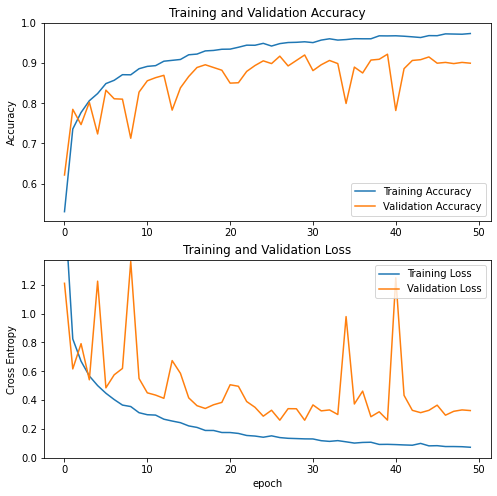

51/51 [==============================] - 3s 62ms/step - loss: 0.2701 - categorical_accuracy: 0.9048
Test loss: 0.2701333165168762, test acc: 0.9048207402229309


<ipython-input-12-917d8bddd54b>:93: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_matrix = confusion_matrix(y_true=y_val_general-1, y_pred=val_preds).astype(np.float)
<ipython-input-12-917d8bddd54b>:94: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_matrix /= val_matrix.astype(np.float).sum(axis=1)
<ipython-input-12-917d8bddd54b>:9

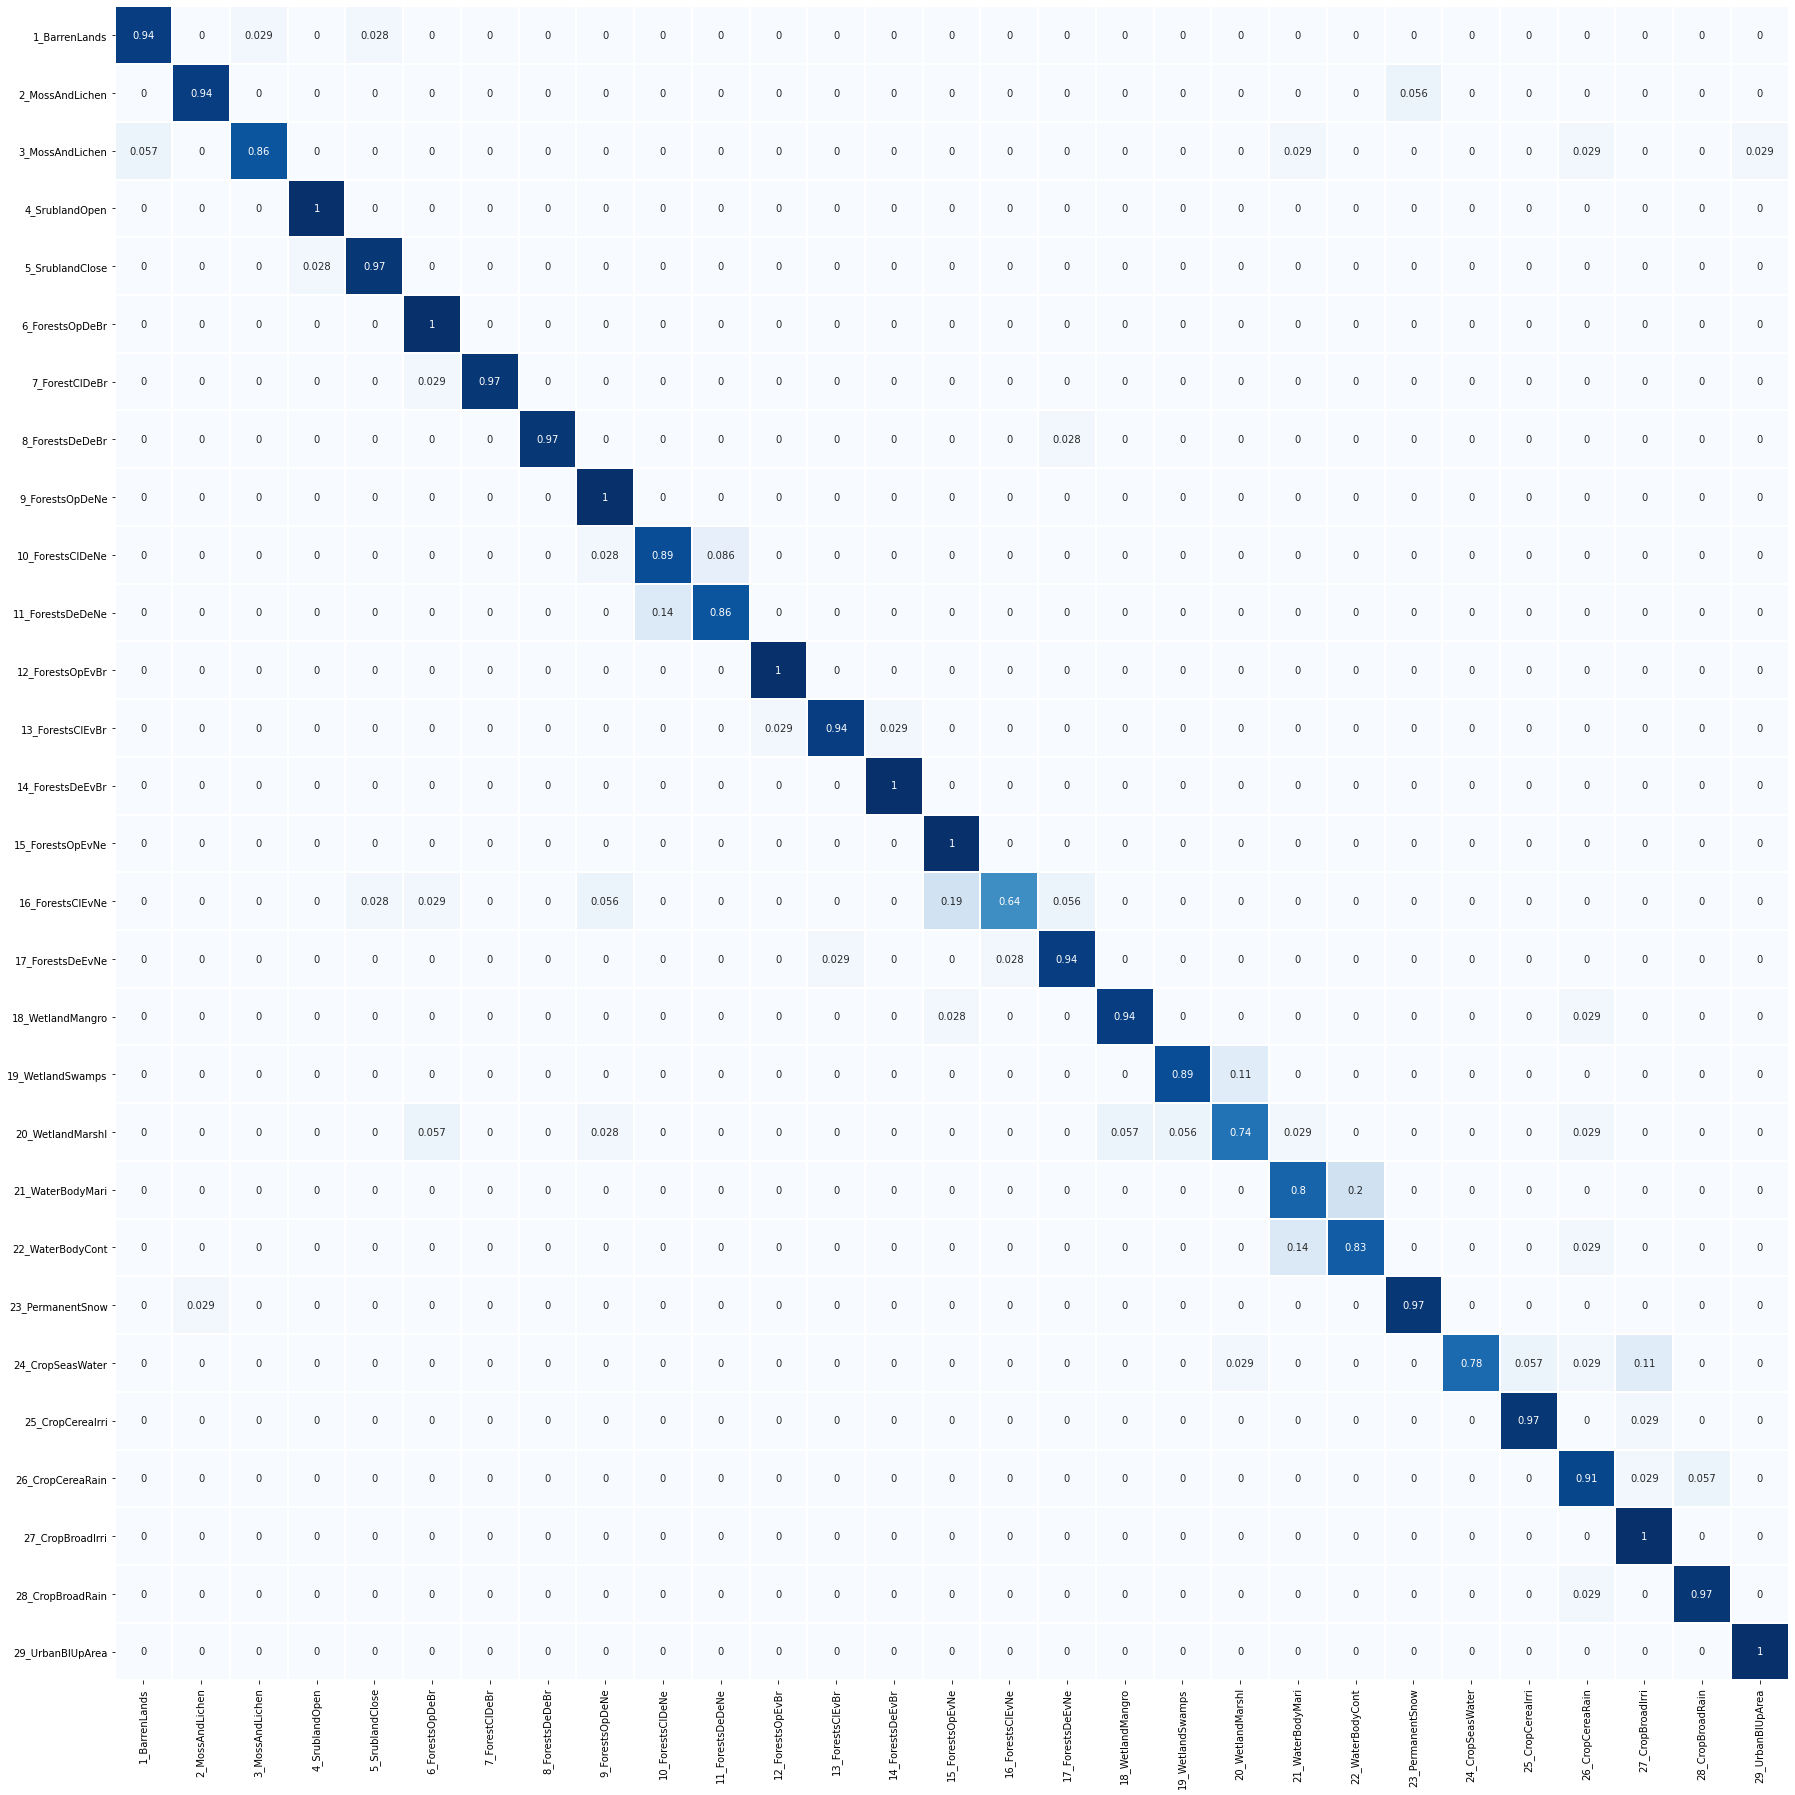

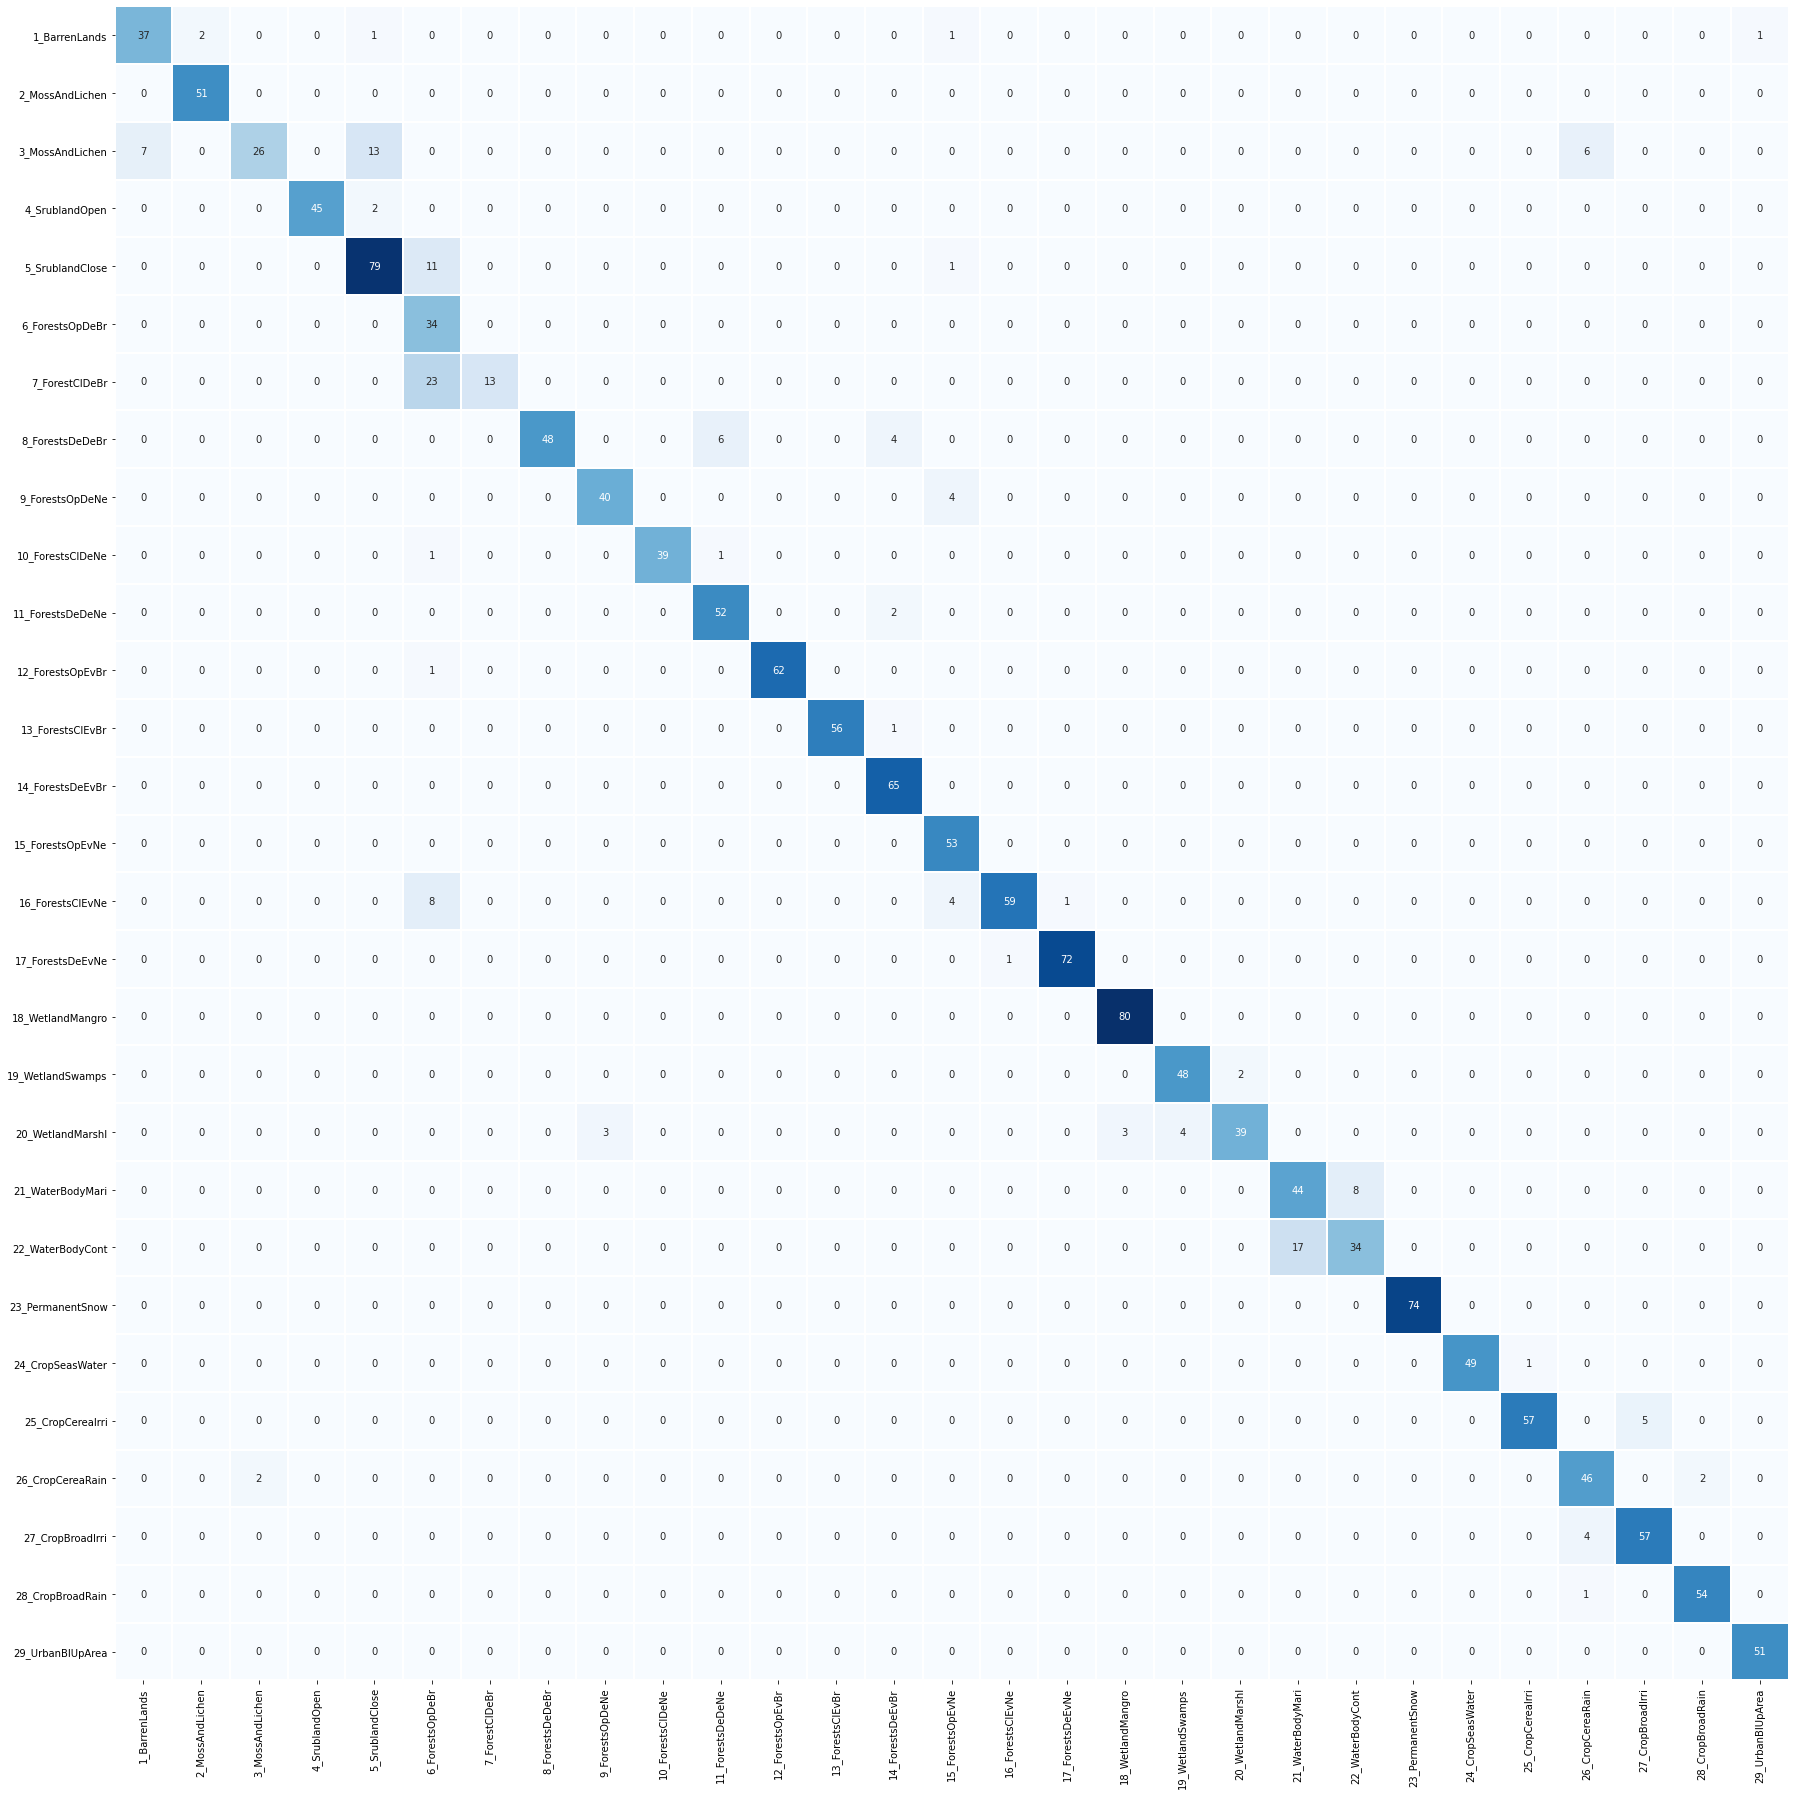

In [12]:
nclasses = len(np.unique(y_train))
img_shape = x_train.shape[1:4]

y_train_coded = tf.one_hot(y_train_general-1, depth=nclasses, on_value=1, off_value=0)
y_val_coded = tf.one_hot(y_val_general-1, depth=nclasses, on_value=1, off_value=0)
y_test_coded = tf.one_hot(y_test_general-1, depth=nclasses, on_value=1, off_value=0)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train_coded)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val), tf.convert_to_tensor(y_val_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test), tf.convert_to_tensor(y_test_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

print(x_train.shape)
print(y_train.shape)

datagen = ImageDataGenerator(width_shift_range=0.3,
                             height_shift_range=0.3,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=180,
                             #zoom_range=[0.7, 1/0.7]
                             )

val_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

it = datagen.flow(x_train, y_train_coded, batch_size=32)
val_it = val_generator.flow(x_val, y_val_coded)
test_it = test_generator.flow(x_test, y_test_coded)

def create_model(base_model):
  base_model.trainable = True
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nclasses, activation='softmax')
  ])
  return model


def train_evaluate_model(model, name, lr=0.0001):
  earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    verbose=1,
    mode='max',
    patience=10,
    restore_best_weights=True
  )
  #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(it,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])
  model.save_weights('david/modelos/model' +subida + '.h5')

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,(np.max(val_loss)+0.01)])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  test_loss, test_acc = model.evaluate(test_batches)
  print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))
  
  val_preds = np.argmax(model.predict(x_val), axis=-1)
  val_matrix = confusion_matrix(y_true=y_val_general-1, y_pred=val_preds).astype(np.float)
  val_matrix /= val_matrix.astype(np.float).sum(axis=1)


  test_preds = np.argmax(model.predict(x_test), axis=-1)
  test_matrix = confusion_matrix(y_true=y_test_general-1, y_pred=test_preds).astype(np.float)

  
  fig, ax = plt.subplots(figsize=(30, 50))         # Sample figsize in inches
  sns.heatmap(val_matrix, annot=True, cmap='Blues', cbar=False, linewidths=1, square=True, xticklabels=axlabs, yticklabels=axlabs)
  plt.show()

  fig, ax = plt.subplots(figsize=(30, 50))         # Sample figsize in inches
  sns.heatmap(test_matrix, annot=True, cmap='Blues', cbar=False, linewidths=1, square=True, xticklabels=axlabs, yticklabels=axlabs)
  plt.show()
  
  
def prep_finetuning(model, from_layer):
  model.layers[0].trainable = True
  for layer in model.layers[0].layers[:from_layer]:
    layer.trainable =  False


def predictions_file(model):
  predictions = model.predict(x_test)
  preds = np.argmax(predictions, axis=-1) + 1
  output = pd.DataFrame({'id.jpg': names_test, 'label':preds})
  output.to_csv('david/predicciones/pred' + subida + '.csv', header=True, index=False)
    
    
base = tf.keras.applications.ResNet101(include_top = False, weights='imagenet',
                                         input_shape=img_shape, pooling='max')
model_avgg = create_model(base)



train_evaluate_model(model_avgg, 'avgg19_256_128')

if load_file is not None:
    model_avgg.load_weights(load_file)

predictions_file(model_avgg)

#m_avgg = load_model(path_models + 'avgg19_256_128.h5')
#prep_finetuning(m_avgg, 20)
#train_evaluate_model(m_avgg, 'avgg19_256_128_v2', 0.00001)

Segundo modelo

In [13]:
"""
subida = "6"

load_file = None

batch_size = 32
shuffle_buffer_size = 1000

nclasses = len(np.unique(y_train))
img_shape = x_train.shape[1:4]

x_train2 = x_train.copy()
x_val2 = x_val.copy()
x_test2 = x_test.copy()

for i in range(x_train2.shape[0]):
    x_train2[i] = tf.image.adjust_saturation(x_train2[i], 2)

for i in range(x_val2.shape[0]):
    x_val2[i] = tf.image.adjust_saturation(x_val2[i], 2)

for i in range(x_test2.shape[0]):
    x_test2[i] = tf.image.adjust_saturation(x_test2[i], 2)

y_train_coded = tf.one_hot(y_train-1, depth=nclasses, on_value=1, off_value=0)
y_val_coded = tf.one_hot(y_val-1, depth=nclasses, on_value=1, off_value=0)
y_test_coded = tf.one_hot(y_test-1, depth=nclasses, on_value=1, off_value=0)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train2), tf.convert_to_tensor(y_train_coded)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val2), tf.convert_to_tensor(y_val_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test2), tf.convert_to_tensor(y_test_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)


nclasses = 29
epochs = 70

datagen = ImageDataGenerator(#width_shift_range=0.3,
                             #height_shift_range=0.3,
                             #horizontal_flip=True,
                             #vertical_flip=True,
                             #rotation_range=180,
                             #zoom_range=[0.7, 1/0.7]
                             )

val_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

it = datagen.flow(x_train2, y_train_coded, batch_size=32)
val_it = val_generator.flow(x_val2, y_val_coded)
test_it = test_generator.flow(x_test2, y_test_coded)


##########################################################################################
##########################################################################################
##########################################################################################


base = tf.keras.applications.ResNet50(include_top = False, weights='imagenet',
                                         input_shape=img_shape, pooling='max')
model_avgg = create_model(base)


if load_file is not None:
    model_avgg.load_weights(load_file)
train_evaluate_model(model_avgg, 'avgg19_256_128')

predictions_file(model_avgg)

#m_avgg = load_model(path_models + 'avgg19_256_128.h5')
#prep_finetuning(m_avgg, 20)
#train_evaluate_model(m_avgg, 'avgg19_256_128_v2', 0.00001)
"""

'\nsubida = "6"\n\nload_file = None\n\nbatch_size = 32\nshuffle_buffer_size = 1000\n\nnclasses = len(np.unique(y_train))\nimg_shape = x_train.shape[1:4]\n\nx_train2 = x_train.copy()\nx_val2 = x_val.copy()\nx_test2 = x_test.copy()\n\nfor i in range(x_train2.shape[0]):\n    x_train2[i] = tf.image.adjust_saturation(x_train2[i], 2)\n\nfor i in range(x_val2.shape[0]):\n    x_val2[i] = tf.image.adjust_saturation(x_val2[i], 2)\n\nfor i in range(x_test2.shape[0]):\n    x_test2[i] = tf.image.adjust_saturation(x_test2[i], 2)\n\ny_train_coded = tf.one_hot(y_train-1, depth=nclasses, on_value=1, off_value=0)\ny_val_coded = tf.one_hot(y_val-1, depth=nclasses, on_value=1, off_value=0)\ny_test_coded = tf.one_hot(y_test-1, depth=nclasses, on_value=1, off_value=0)\n\ntrain_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train2), tf.convert_to_tensor(y_train_coded)))\nval_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val2), tf.convert_to_tensor(y_val_coded)))\n

Realizamos la predicción sobre el conjunto de test

In [14]:
if jerarquico:
    srubland_dict = {4:1, 5:2}
    forest_1_dict = {9:1, 10:2, 11:3}
    forest_2_dict = {15:1, 16:2}
    wetland_dict = {18:1, 19:2, 20:3}
    water_dict = {21:1, 22:2}
    crop_dict = {25:1, 26:2, 27:3, 28:4}

    list_of_dicts = [srubland_dict, forest_1_dict, forest_2_dict, wetland_dict, water_dict, crop_dict]

    list_models = []

    subida="7"

    for dicti in list_of_dicts:
        x_train_new = []
        x_val_new = []
        x_test_new = []
        y_train_new = []
        y_test_new = []
        y_val_new = []

        nclasses = len(dicti.keys())

        for i in range(x_train.shape[0]):
            if y_train[i] in dicti.keys():
                x_train_new.append(x_train[i])
                y_train_new.append(dicti[y_train[i]])

        for i in range(x_val.shape[0]):
            if y_val[i] in dicti.keys():
                x_val_new.append(x_val[i])
                y_val_new.append(dicti[y_val[i]])

        for i in range(x_test.shape[0]):
            if y_test[i] in dicti.keys():
                x_test_new.append(x_test[i])
                y_test_new.append(dicti[y_test[i]])

        x_train_new = np.array(x_train_new)
        x_val_new = np.array(x_val_new)
        x_test_new = np.array(x_test_new)
        y_train_new = np.array(y_train_new)
        y_val_new = np.array(y_val_new)
        y_test_new = np.array(y_test_new)



        y_train_coded = tf.one_hot(y_train_new-1, depth=nclasses, on_value=1, off_value=0)
        y_val_coded = tf.one_hot(y_val_new-1, depth=nclasses, on_value=1, off_value=0)
        y_test_coded = tf.one_hot(y_test_new-1, depth=nclasses, on_value=1, off_value=0)

        train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train_new), tf.convert_to_tensor(y_train_coded)))
        val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val_new), tf.convert_to_tensor(y_val_coded)))
        test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test_new), tf.convert_to_tensor(y_test_coded)))

        train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
        val_batches = val_dataset.batch(batch_size)
        test_batches = test_dataset.batch(batch_size)

        print(x_train.shape)
        print(y_train.shape)

        epochs = 70

        datagen = ImageDataGenerator(#width_shift_range=0.3,
                                     #height_shift_range=0.3,
                                     #horizontal_flip=True,
                                     #vertical_flip=True,
                                     #rotation_range=180,
                                     #zoom_range=[0.7, 1/0.7]
                                     )

        val_generator = ImageDataGenerator()
        test_generator = ImageDataGenerator()

        it = datagen.flow(x_train_new, y_train_coded, batch_size=32)
        val_it = val_generator.flow(x_val_new, y_val_coded)
        test_it = test_generator.flow(x_test_new, y_test_coded)


        print(model_avgg.summary())
        new_model_avgg = tf.keras.models.clone_model(model_avgg)

        new_model_avgg.pop()

        """
        model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(nclasses, activation='softmax')
      ])
        """


        new_model_avgg = tf.keras.Sequential([
        new_model_avgg,
        tf.keras.layers.Dense(nclasses, activation='softmax')

      ])
        print(new_model_avgg.summary())

        train_evaluate_model(new_model_avgg, 'avgg19_256_128')

        list_models.append(new_model_avgg)


    

Calculamos algunas medidas de interés sobre la predicción realizada

In [15]:
# Final predictions

if jerarquico:
    srubland_dict = {4:1, 5:2}
    forest_1_dict = {9:1, 10:2, 11:3}
    forest_2_dict = {15:1, 16:2}
    wetland_dict = {18:1, 19:2, 20:3}
    water_dict = {21:1, 22:2}
    crop_dict = {25:1, 26:2, 27:3, 28:4}

    dict_clases = {1:1, 2:2, 3:3, 4:4, 5:4, 6:5, 7:6, 8:7, 9:8, 10:8,
                   11:8, 12:9, 13:10, 14:11, 15:12, 16:12, 17:13, 18:14, 19:14, 20:14,
                   21:15, 22:15, 23:16, 24:17, 25:18, 26:18, 27:18, 28:18, 29:19}


    y_train_coded = tf.one_hot(y_train_general-1, depth=nclasses, on_value=1, off_value=0)
    y_val_coded = tf.one_hot(y_val_general-1, depth=nclasses, on_value=1, off_value=0)
    y_test_coded = tf.one_hot(y_test_general-1, depth=nclasses, on_value=1, off_value=0)

    train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train_coded)))
    val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val), tf.convert_to_tensor(y_val_coded)))
    test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test), tf.convert_to_tensor(y_test_coded)))

    train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
    val_batches = val_dataset.batch(batch_size)
    test_batches = test_dataset.batch(batch_size)

    print(model_avgg.summary())

    test_preds = np.argmax(model_avgg.predict(x_test), axis=-1) + 1

    print(np.max(test_preds))

    for i in range(test_preds.shape[0]):

        key_list=list(dict_clases.keys())
        val_list=list(dict_clases.values())
        print(test_preds[i])
        ind=val_list.index(test_preds[i])
        test_preds[i] = key_list[ind]
        print("---\n ", test_preds[i])
        if test_preds[i] == 4:
            new_pred = np.argmax(list_models[0].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(srubland_dict.keys())
            print(key_list)
            val_list=list(srubland_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]

        if test_preds[i] == 9:
            new_pred = np.argmax(list_models[1].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(forest_1_dict.keys())
            print(key_list)
            val_list=list(forest_1_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]

        if test_preds[i] == 15:
            new_pred = np.argmax(list_models[2].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(forest_2_dict.keys())
            print(key_list)
            val_list=list(forest_2_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]

        if test_preds[i] == 18:
            new_pred = np.argmax(list_models[3].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(wetland_dict.keys())
            print(key_list)
            val_list=list(wetland_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]

        if test_preds[i] == 21:
            new_pred = np.argmax(list_models[4].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(water_dict.keys())
            print(key_list)
            val_list=list(water_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]

        if test_preds[i] == 25:
            new_pred = np.argmax(list_models[5].predict(np.expand_dims(x_test[i], axis=0))) + 1
            print(new_pred)
            key_list=list(crop_dict.keys())
            print(key_list)
            val_list=list(crop_dict.values())
            print(val_list)
            ind=val_list.index(new_pred)
            print(ind)
            test_preds[i] = key_list[ind]


    print(max(test_preds))


In [16]:
axlabs = [
  "1_BarrenLands",
  "2_MossAndLichen",
  "3_MossAndLichen",
  "4_SrublandOpen",
  "5_SrublandClose",
  "6_ForestsOpDeBr",
  "7_ForestClDeBr",
  "8_ForestsDeDeBr",
  "9_ForestsOpDeNe",
  "10_ForestsClDeNe",
  "11_ForestsDeDeNe",
  "12_ForestsOpEvBr",
  "13_ForestsClEvBr",
  "14_ForestsDeEvBr",
  "15_ForestsOpEvNe",
  "16_ForestsClEvNe",
  "17_ForestsDeEvNe",
  "18_WetlandMangro",
  "19_WetlandSwamps",
  "20_WetlandMarshl",
  "21_WaterBodyMari",
  "22_WaterBodyCont",
  "23_PermanentSnow",
  "24_CropSeasWater",
  "25_CropCerealrri",
  "26_CropCereaRain",
  "27_CropBroadlrri",
  "28_CropBroadRain",
  "29_UrbanBlUpArea",

  ]

print(test_preds)

test_matrix = confusion_matrix(y_true=y_test-1, y_pred=test_preds-1).astype(np.float)
fig, ax = plt.subplots(figsize=(30, 50))         # Sample figsize in inches
sns.heatmap(test_matrix, annot=True, cmap='Blues', cbar=False, linewidths=1, square=True, xticklabels=axlabs, yticklabels=axlabs)
plt.show()

output = pd.DataFrame({'id.jpg': names_test, 'label':test_preds})
output.to_csv('david/predicciones/pred8.csv', header=True, index=False)

print(y_test)
print(test_preds)

print(calcularAccuracy(np.array(y_test), np.array(test_preds)))


NameError: name 'test_preds' is not defined